In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
from collections import OrderedDict
%matplotlib inline
from datetime import datetime
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
#from keras import models, layers, optimizers, regularizers
#from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose



In [2]:
df = pd.read_csv('train_values.csv')
print(f"The dataset contains {len(df)} loan files")

The dataset contains 500000 loan files


In [3]:
df.columns

Index(['row_id', 'loan_type', 'property_type', 'loan_purpose', 'occupancy',
       'loan_amount', 'preapproval', 'msa_md', 'state_code', 'county_code',
       'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'applicant_income', 'population', 'minority_population_pct',
       'ffiecmedian_family_income', 'tract_to_msa_md_income_pct',
       'number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
       'lender', 'co_applicant'],
      dtype='object')

Loan Types: 1. Conventional 2. FHA 3. VA 4. USDA

Loan Purpose: 1. Purchase 2. Home improvement 31. Refinancing 32. Cash-out refinancing 4. Other purpose 5. Not applicable

Occupancy: 1. Principal residence 2. Second residence 3. Investment property

Loan Amount: Disclose the midpoint for the 10000 interval into which the reported value falls (e.g. for a reported value of 117834 disclose 115000 as the midpoint between values = 110000 and < 120000)

Preapproval: 1. Preapproval requested 2. Preapproval not requested

Applicant Income: Scale???

In [4]:
df.head()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,...,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant
0,0,3,1,1,1,70.0,3,18,37,246,...,1,24.0,6203.0,44.230,60588.0,50.933,716.0,2642.0,4536,False
1,1,1,1,3,1,178.0,3,369,52,299,...,1,57.0,5774.0,15.905,54821.0,100.000,1622.0,2108.0,2458,False
2,2,2,1,3,1,163.0,3,16,10,306,...,1,67.0,6094.0,61.270,67719.0,100.000,760.0,1048.0,5710,False
3,3,1,1,1,1,155.0,1,305,47,180,...,1,105.0,6667.0,6.246,78439.0,100.000,2025.0,2299.0,5888,True
4,4,1,1,1,1,305.0,3,24,37,20,...,2,71.0,6732.0,100.000,63075.0,82.200,1464.0,1847.0,289,False


In [5]:
df.drop(['row_id','lender', 'number_of_owner-occupied_units', 'number_of_1_to_4_family_units', 'minority_population_pct', 'minority_population_pct', 'county_code', 'state_code', 'msa_md'], axis=1, inplace=True)

In [6]:
df.head()

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,ffiecmedian_family_income,tract_to_msa_md_income_pct,co_applicant
0,3,1,1,1,70.0,3,2,5,1,24.0,6203.0,60588.0,50.933,False
1,1,1,3,1,178.0,3,1,5,1,57.0,5774.0,54821.0,100.000,False
2,2,1,3,1,163.0,3,2,5,1,67.0,6094.0,67719.0,100.000,False
3,1,1,1,1,155.0,1,2,5,1,105.0,6667.0,78439.0,100.000,True
4,1,1,1,1,305.0,3,2,3,2,71.0,6732.0,63075.0,82.200,False


My target prediction in this model will be loan type, so there are 4 possibilities, but realistically the most common loan types would be conventional and FHA, so this distinction is most important for prediction. It is much easier to predict that someone will utilize the VA benefit if they are indeed a veteran, and USDA make up about 1% of transactions.

In [7]:
CONV = df[df.loan_type==1]
FHA = df[df.loan_type==2]
VA = df[df.loan_type==3]


In [8]:
df.drop(df[df.loan_type==3].index, axis=0, inplace=True)
df.drop(df[df.loan_type==4].index, axis=0, inplace=True)

In [9]:
print(df['loan_type'].isna().sum(), 
      df['applicant_income'].isna().sum(),
      df['occupancy'].isna().sum(),
      df['loan_purpose'].isna().sum(),
      df['preapproval'].isna().sum(),
      df['applicant_ethnicity'].isna().sum(),
      df['applicant_sex'].isna().sum()
     )

0 32354 0 0 0 0 0


In [10]:
df.dropna(inplace=True)

In [11]:
df.replace({False: 0, True: 1}, inplace=True)

In [12]:
df.head()

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,ffiecmedian_family_income,tract_to_msa_md_income_pct,co_applicant
1,1,1,3,1,178.0,3,1,5,1,57.0,5774.0,54821.0,100.00,0
2,2,1,3,1,163.0,3,2,5,1,67.0,6094.0,67719.0,100.00,0
3,1,1,1,1,155.0,1,2,5,1,105.0,6667.0,78439.0,100.00,1
4,1,1,1,1,305.0,3,2,3,2,71.0,6732.0,63075.0,82.20,0
5,1,1,3,1,133.0,3,2,5,2,51.0,6078.0,82745.0,96.55,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a248a62d0>,
      dtype=object)

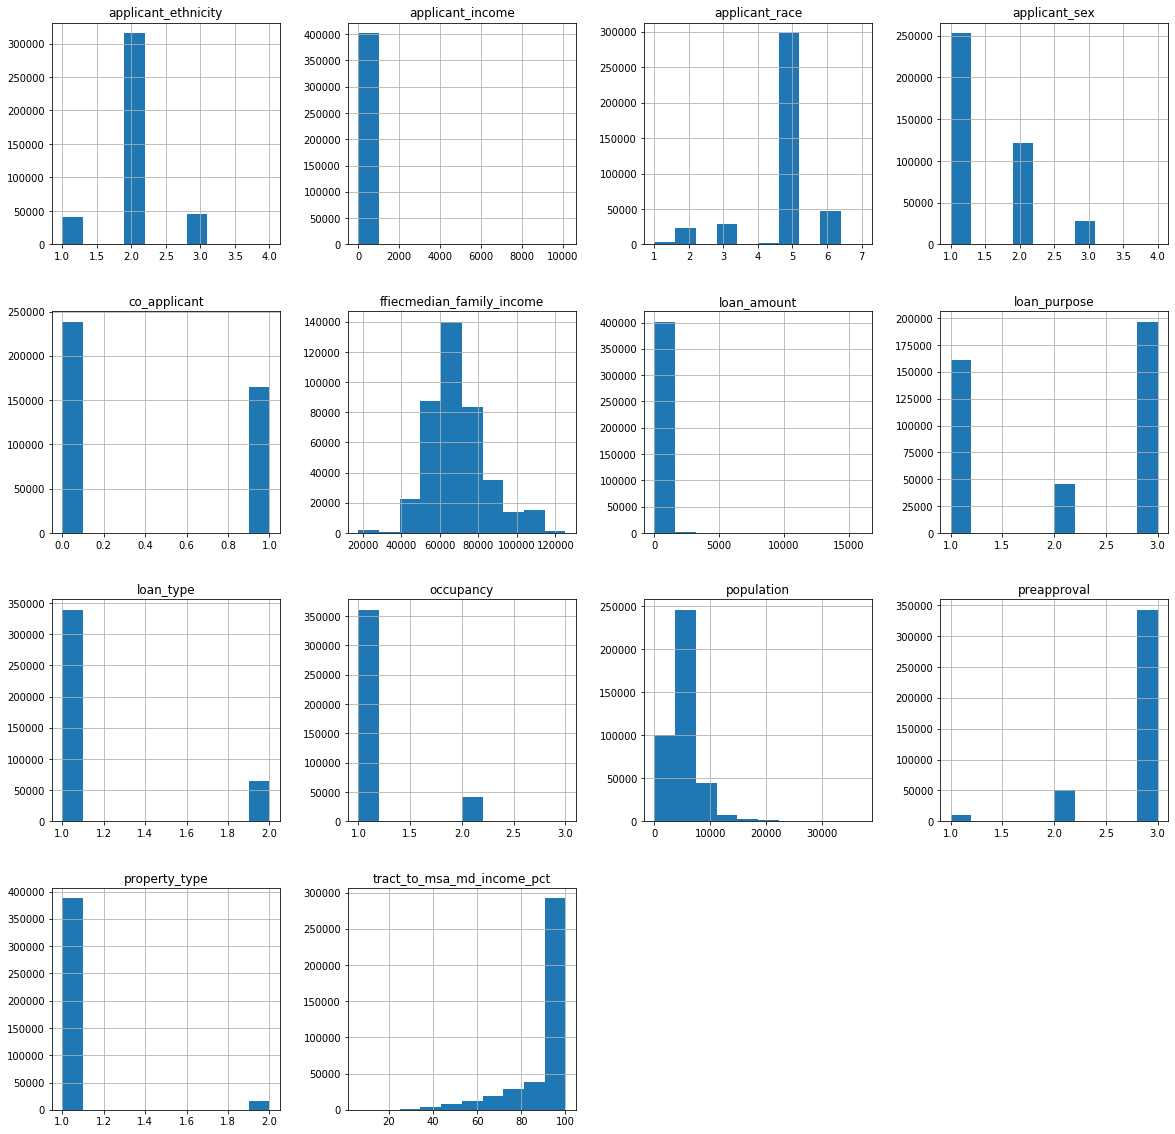

In [13]:
df.hist(figsize=(20,20))


In [14]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

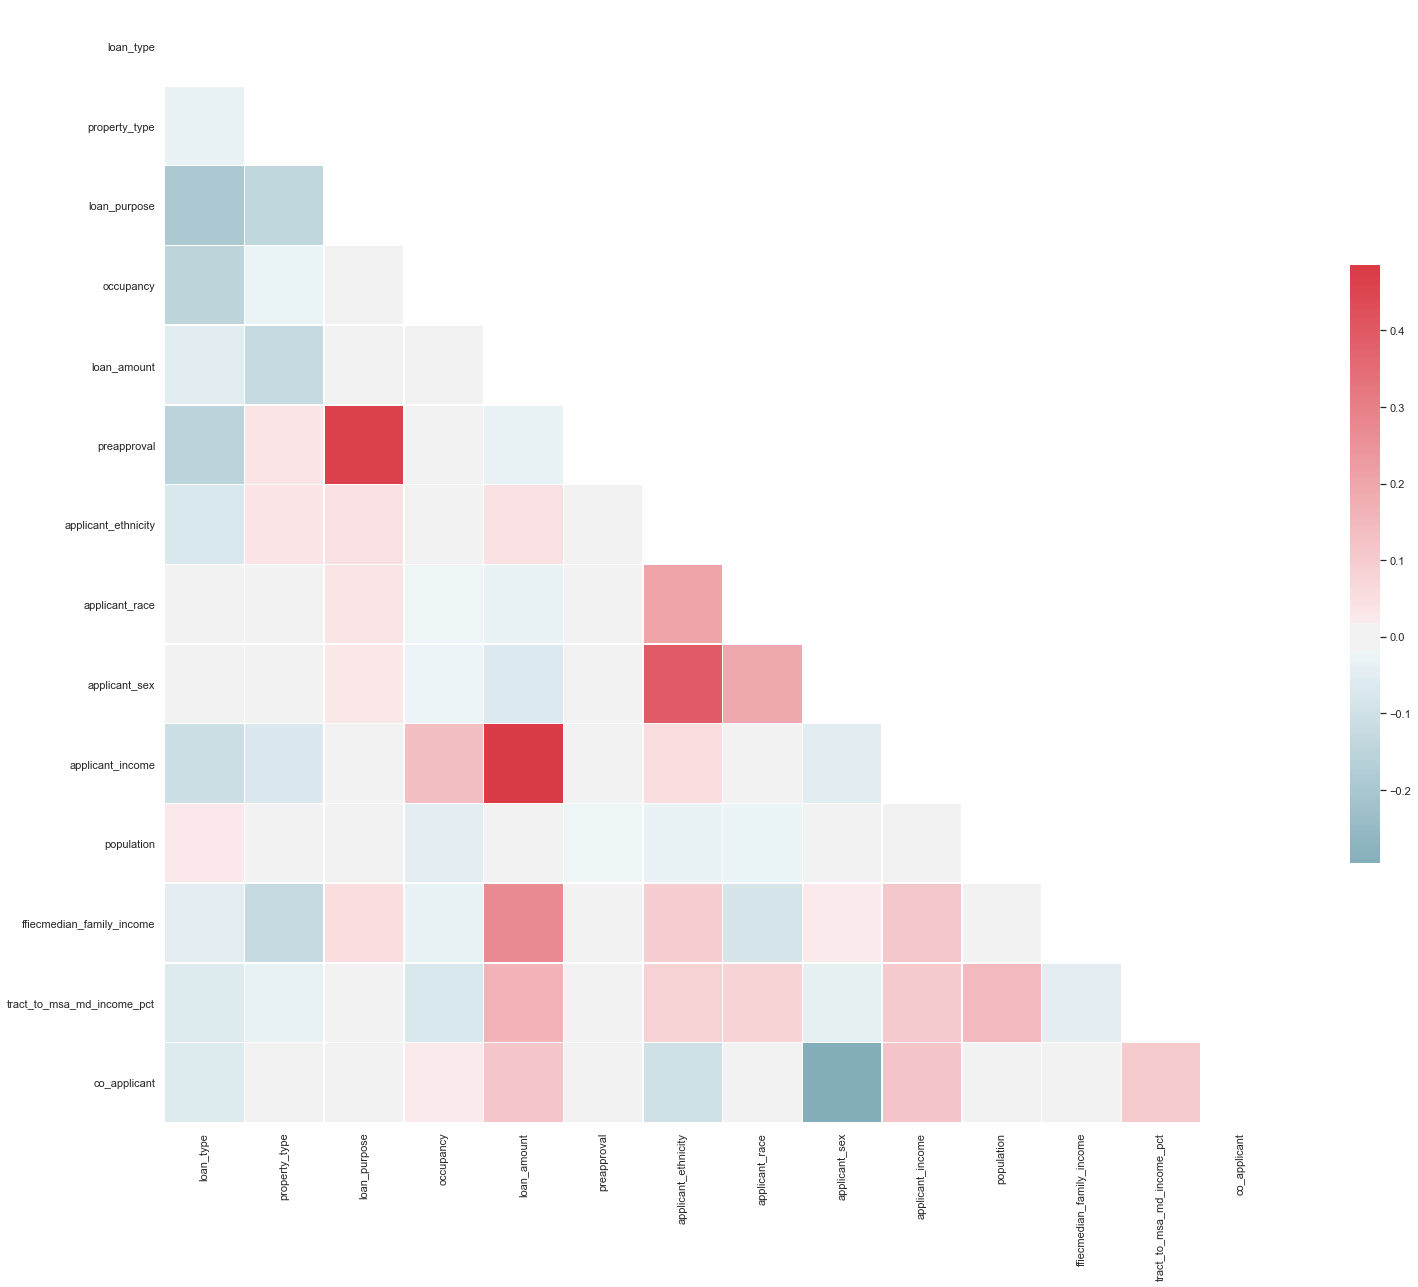

In [15]:
multi_collinearity_heatmap(df, figsize=(25,22))

In [16]:
df.drop(['preapproval','loan_amount'],axis=1,inplace=True)

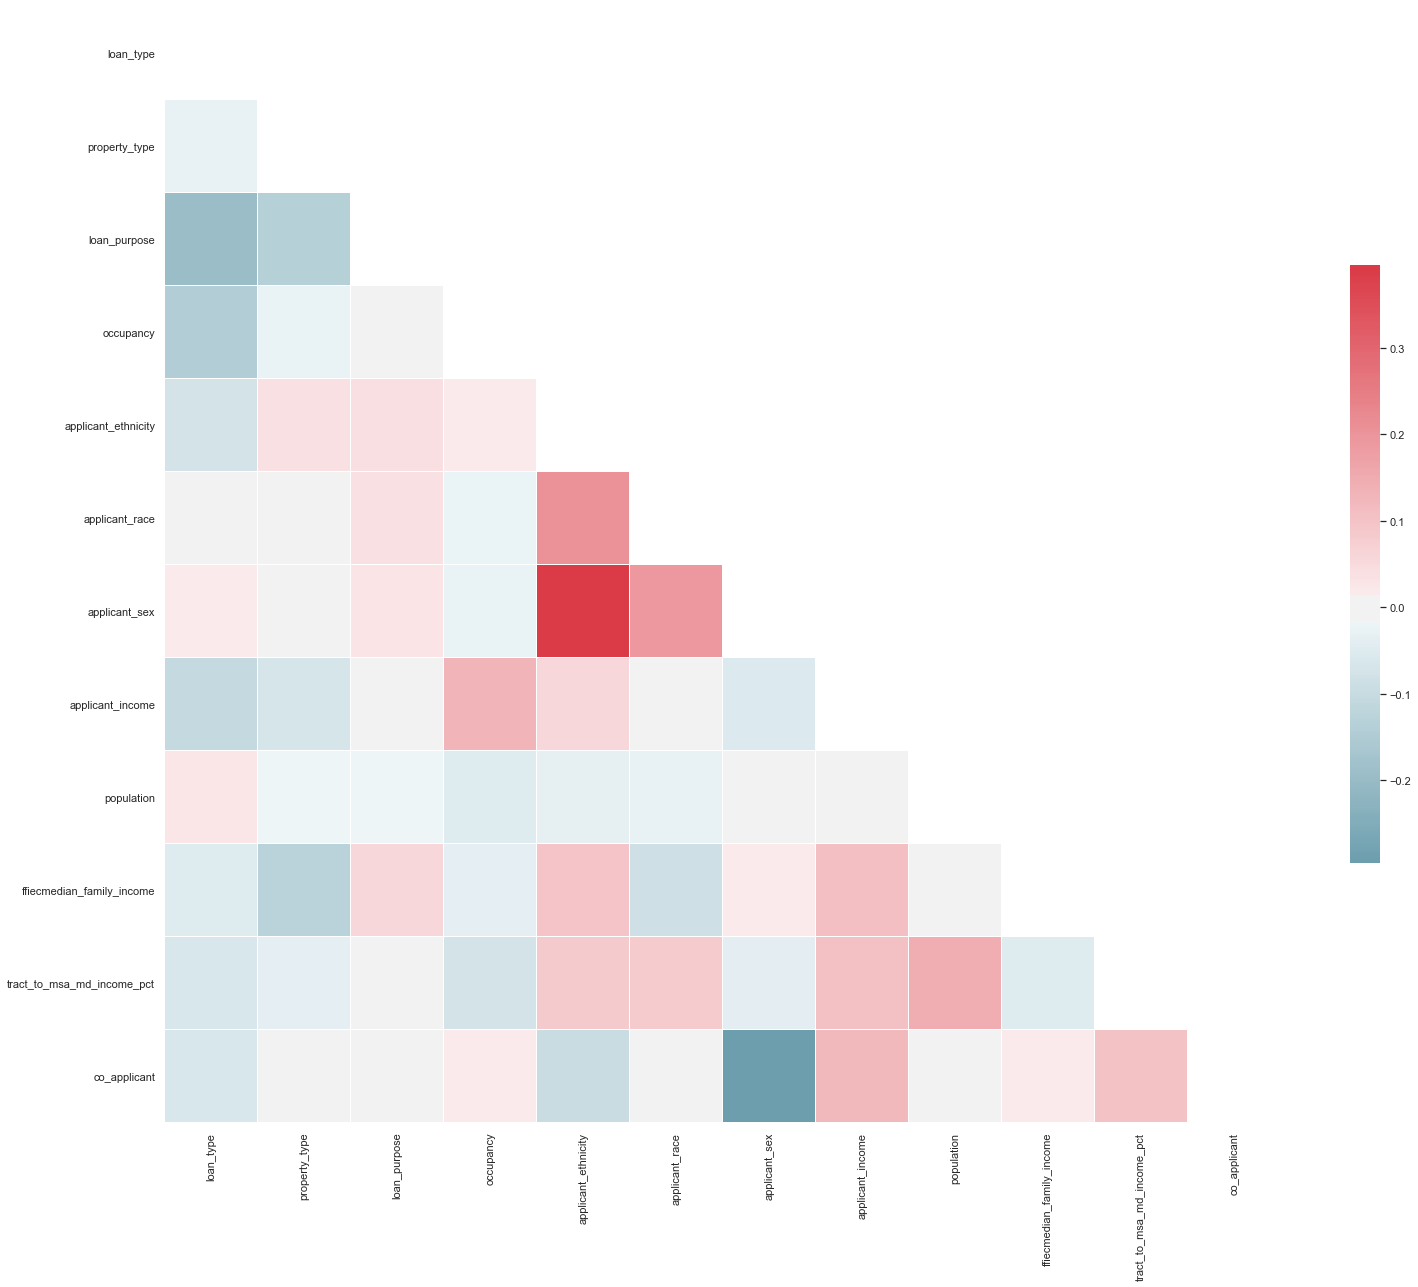

In [17]:
multi_collinearity_heatmap(df, figsize=(25,22))

In [18]:
# Separating X and y
X = df.drop('loan_type', axis=1)
y = df.loan_type

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [21]:
from sklearn.ensemble import RandomForestClassifier

rfr = RandomForestClassifier(n_estimators=100, max_depth=10)
#param_grid = [
  #{'max_depth': [5,15,20]}
#]
#grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=3, verbose=-1)
#grid_search.fit(X_train, y_train)

rfr.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [22]:
n_nodes = []
max_depths = []

for ind_tree in rfr.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 1070
Average maximum depth 10


In [24]:
train_rf_predictions = rfr.predict(X_train)
train_rf_probs = rfr.predict_proba(X_train)[:, 1]

rf_predictions = rfr.predict(X_test)
rf_probs = rfr.predict_proba(X_test)[:, 1]

In [46]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))], pos_label=2)
    model_fpr, model_tpr, _ = roc_curve(y_test, probs, pos_label=2)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

Recall Baseline: 1.0 Test: 0.98 Train: 0.98
Precision Baseline: 0.84 Test: 0.86 Train: 0.86
Roc Baseline: 0.5 Test: 0.8 Train: 0.82


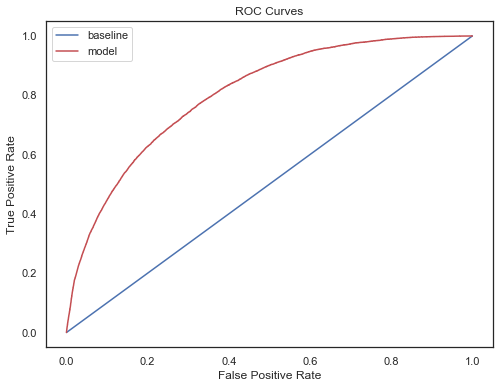

In [47]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

Questions I have:

1. y_true has to be "true binary labels" either -1, 1 or 0, 1 and it seems like it's not here, because I was getting an error if I didn't specify pos_label parameter in the roc_curve function. 
2. When I specify pos_label = 1, the curve is inverted, and when it is 2, it is like the above. Not sure which one is right, except that based on the stats the test and train are higher than the baseline, so I'm thinking 2 (?)